## Importing libraries and dependencies

In [6]:
!gsutil -m cp gs://dtire-special-storage/archive.zip .
!ls -l

Copying gs://dtire-special-storage/archive.zip...
Resuming download for ./archive.zip component 0
Resuming download for ./archive.zip component 2
Resuming download for ./archive.zip component 1
Resuming download for ./archive.zip component 3
\ [1/1 files][707.6 MiB/707.6 MiB] 100% Done                                    
Operation completed over 1 objects/707.6 MiB.                                    
total 724612
-rw-r--r-- 1 root root 741994332 May 24 06:26 archive.zip
drwxr-xr-x 1 root root      4096 May 17 13:39 sample_data


In [7]:
!unzip -q archive.zip

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

# HyperParameter


In [9]:
train_path='./Tire Textures/training_data'
test_path='./Tire Textures/testing_data'
EPOCHS=13
BATCH_SIZE=20
RANDOM_SEED=16

# Data visualization

In [10]:
labels=os.listdir(train_path)
labels

['normal', 'cracked']

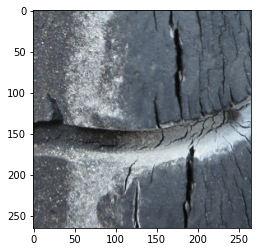

In [11]:
train_cracked=train_path+"/cracked/"
train_normal=train_path+"/normal/"
len(os.listdir(train_cracked))
random_num=np.random.randint(0,len(os.listdir(train_cracked)))
pic_path=os.listdir(train_cracked)[random_num]

img_path=train_cracked + pic_path
plt.imshow(plt.imread(img_path))

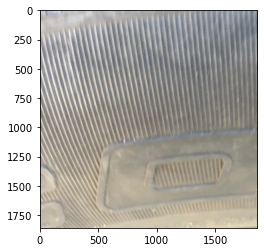

In [12]:
train_normal=train_path+"/normal/"
len(os.listdir(train_normal))
random_num=np.random.randint(0,len(os.listdir(train_normal)))
pic_path=os.listdir(train_normal)[random_num]

img_path=train_normal + pic_path
plt.imshow(plt.imread(img_path))

# Preparing our dataset

In [13]:
def process(data):
    path=Path(data) #get the path
    filepaths=list(path.glob(r"*/*.jpg")) # get all the subpath
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) #get the label for each subpath
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # concat the series of filepaths and label to be one dataframe
    return df

In [16]:
train=process(train_path)
test=process(test_path)

# merge the dataset
df_full = pd.concat([train, test], axis=0)
df_full = df_full.sample(frac=1, random_state=RANDOM_SEED)

# split the full dataset by 0.8/0.2 to train and test
sliceIdx= int(0.8*len(df_full))
df_train = df_full.iloc[:sliceIdx,:]
df_test_full = df_full.iloc[sliceIdx:,:]

# split the test dataset to val and test
sliceIdx= int(0.5*len(df_test_full))
df_test = df_test_full.iloc[:sliceIdx,:]
df_val = df_test_full.iloc[sliceIdx:,:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

print(df_test['labels'].value_counts()['cracked'])

(822, 2)
(103, 2)
(103, 2)
53


In [17]:
train_generator = ImageDataGenerator( preprocessing_function=preprocess_input, rotation_range = 10, horizontal_flip=True)
val_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)

In [18]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,                                               
                                                random_seed=RANDOM_SEED)

val_image=train_generator.flow_from_dataframe(dataframe=df_val,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,  
                                                                                             
                                                random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(
                                                dataframe=df_test,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,
                                                random_seed=RANDOM_SEED
)

Found 822 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.


# Model building

In [19]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False #We don't want to train again the resnet



94781440/94765736 [==============================] - 2s 0us/step


In [20]:
inputs = pretrained_model.input


x = Dense(152, activation='relu')(pretrained_model.output)
x = Dense(64, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(1, activation='sigmoid')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training

In [22]:
mo_fit=model.fit(train_image,
                 epochs=EPOCHS,
                 validation_data=val_image,
                 verbose = 1)

Epoch 1/13
42/42 [==============================] - 61s 1s/step - loss: 0.8255 - accuracy: 0.7664 - val_loss: 0.3261 - val_accuracy: 0.8350
Epoch 2/13
42/42 [==============================] - 44s 1s/step - loss: 0.2926 - accuracy: 0.8820 - val_loss: 0.3145 - val_accuracy: 0.9029
Epoch 3/13
42/42 [==============================] - 43s 1s/step - loss: 0.1728 - accuracy: 0.9270 - val_loss: 0.2963 - val_accuracy: 0.9029
Epoch 4/13
42/42 [==============================] - 43s 1s/step - loss: 0.2858 - accuracy: 0.9075 - val_loss: 0.6662 - val_accuracy: 0.7573
Epoch 5/13
42/42 [==============================] - 43s 1s/step - loss: 0.1828 - accuracy: 0.9185 - val_loss: 0.3489 - val_accuracy: 0.8932
Epoch 6/13
42/42 [==============================] - 43s 1s/step - loss: 0.1106 - accuracy: 0.9550 - val_loss: 0.2429 - val_accuracy: 0.9320
Epoch 7/13
42/42 [==============================] - 43s 1s/step - loss: 0.0804 - accuracy: 0.9647 - val_loss: 0.2991 - val_accuracy: 0.9126
Epoch 8/13
42/42 [==

# Performance plots

No handles with labels found to put in legend.


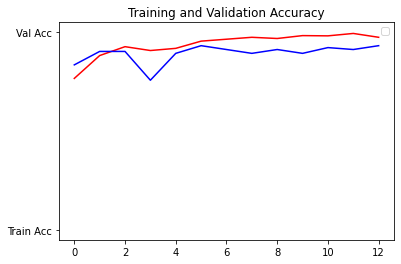

No handles with labels found to put in legend.


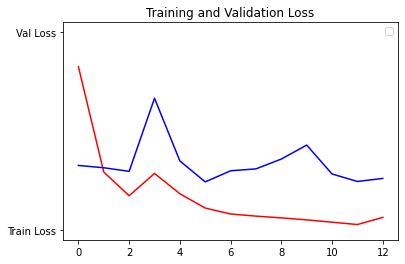

In [23]:
acc = mo_fit.history['accuracy']
val_acc = mo_fit.history['val_accuracy']
loss = mo_fit.history['loss']
val_loss = mo_fit.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'Train Acc')
plt.plot(epochs, val_acc, 'b', 'Val Acc')
plt.title("Training and Validation Accuracy")
plt.legend(loc=0)
plt.show()
print('')
plt.plot(epochs, loss, 'r', 'Train Loss')
plt.plot(epochs, val_loss, 'b', 'Val Loss')
plt.legend(loc=0)
plt.title("Training and Validation Loss")
plt.show()

# Evaluation on test set

In [24]:
model.evaluate(test_image)

6/6 [==============================] - 4s 619ms/step - loss: 0.3055 - accuracy: 0.9320


[0.3054896295070648, 0.9320388436317444]

# Save the Model

In [25]:
model.save("saved_models/model_v1/")

INFO:tensorflow:Assets written to: saved_models/model_v1/assets


In [26]:
!zip -r saved_models.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/model_v1/ (stored 0%)
  adding: saved_models/model_v1/variables/ (stored 0%)
  adding: saved_models/model_v1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_models/model_v1/variables/variables.index (deflated 80%)
  adding: saved_models/model_v1/saved_model.pb (deflated 92%)
  adding: saved_models/model_v1/assets/ (stored 0%)
  adding: saved_models/model_v1/keras_metadata.pb (deflated 96%)


Test with your arbitrary image

In [30]:
image_path = "test_normal.jpg"
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_arr = tf.keras.utils.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0)

model.predict(img_arr)

array([[0.94151217]], dtype=float32)